In [1]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from feature_extractors.transformer_feature_extractor import TransformerFeatureExtractor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

seed = 42

### Import Experiment Dataset

In [2]:
X_bigbird = pickle.load(open('pickles/pickled_datasets/seed_42/out_of_domain_X_bigbird_fine_tuned_chunks.pkl', 'rb'))
X_normal = pickle.load(open('pickles/pickled_datasets/seed_42/out_of_domain_X_normal_chunks.pkl', 'rb')).to_numpy()
experiment_df = pickle.load(open('pickles/pickled_datasets/seed_42/out_of_domain_experiment_dataframe_clean_chunks.pkl', 'rb'))

## Randomly Sample 1000 Chunks

In [3]:
np.random.seed(seed)
random_indices = np.random.choice(len(X_bigbird), size=1000, replace=False)

random_texts = experiment_df.iloc[random_indices].text.values.tolist()
random_labels = experiment_df.iloc[random_indices].label.values.tolist()

### Create Slices of Text Chunk 10% 20% 40% and 80% of Total Text Length

In [4]:
texts_10, texts_20, texts_40, texts_80 = [], [], [], []

def get_n_sentences(text, n):
  sentences = text.split('\n')
  return '\n'.join(sentences[:n])

for chunk in random_texts:
    texts_10.append(get_n_sentences(chunk, 10))
    texts_20.append(get_n_sentences(chunk, 20))
    texts_40.append(get_n_sentences(chunk, 40))
    texts_80.append(get_n_sentences(chunk, 80))


#### Create Embeddings for Slices

In [ ]:
big_bird_feature_extractor = TransformerFeatureExtractor(model_name='fine_tuned_models/out_of_domain_bigbird_roberta_base_clean_chunks', max_length=2048)

embeddings_10 = big_bird_feature_extractor.transform(texts_10)
embeddings_20 = big_bird_feature_extractor.transform(texts_20)
embeddings_40 = big_bird_feature_extractor.transform(texts_40)
embeddings_80 = big_bird_feature_extractor.transform(texts_80)
embeddings_full = big_bird_feature_extractor.transform(random_texts)

Some weights of the model checkpoint at fine_tuned_models/out_of_domain_bigbird_roberta_base_clean_chunks were not used when initializing BigBirdModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Extracting features: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (4350 > 4096). Running this sequence through the model will result in indexing errors
Extracting features: 10

#### Create features for slices

In [6]:
normal_feature_extractor = pickle.load(open('pickles/normal_feature_extractor_seed_42_chunks.pkl', 'rb'))

features = []

for index, slice in tqdm(enumerate([texts_10, texts_20, texts_40, texts_80, random_texts]), total=5):
    word_ngram_features = normal_feature_extractor.get_word_ngram_features(slice, normalize=False)
    char_ngram_features = normal_feature_extractor.get_char_ngram_features(slice, normalize=False)
    edit_distance = normal_feature_extractor.get_edit_distance(slice, normalize=False).reshape(-1,1)
    substitution_features= normal_feature_extractor.get_substitution_features(slice, normalize=False)
    grammar_features = normal_feature_extractor.get_grammar_features(slice)
    function_word_features = normal_feature_extractor.get_function_word_features(slice, normalize=False)
    pos_features = normal_feature_extractor.get_pos_features(slice, normalize=False)
    average_sentence_length = normal_feature_extractor.get_average_sentence_length(slice).reshape(-1,1)

    features.append(np.concatenate([word_ngram_features, char_ngram_features, edit_distance, substitution_features,
                                grammar_features, function_word_features, pos_features, average_sentence_length], axis=1))

normal_features_10 = features[0]
normal_features_20 = features[1]
normal_features_40 = features[2]
normal_features_80 = features[3]
normal_features_full = features[4]



  0%|          | 0/5 [00:00<?, ?it/s]

Creating word ngram features...
Creating char ngram features...


Extracting Grammar Features: 100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]
Extracting Function Word Features: 1000it [00:00, 1091.33it/s]
Extracting POS Features: 1000it [00:09, 109.74it/s]
 20%|██        | 1/5 [02:31<10:07, 151.80s/it]

Creating word ngram features...
Creating char ngram features...


Extracting Grammar Features: 100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]
Extracting Function Word Features: 1000it [00:01, 578.97it/s]
Extracting POS Features: 1000it [00:17, 56.63it/s]
 40%|████      | 2/5 [06:50<10:44, 214.67s/it]

Creating word ngram features...
Creating char ngram features...


Extracting Grammar Features: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]
Extracting Function Word Features: 1000it [00:03, 308.73it/s]
Extracting POS Features: 1000it [00:35, 28.47it/s]
 60%|██████    | 3/5 [14:30<10:53, 326.52s/it]

Creating word ngram features...
Creating char ngram features...


Extracting Grammar Features: 100%|██████████| 1000/1000 [12:42<00:00,  1.31it/s]
Extracting Function Word Features: 1000it [00:06, 156.16it/s]
Extracting POS Features: 1000it [01:07, 14.71it/s]
 80%|████████  | 4/5 [29:05<09:03, 543.41s/it]

Creating word ngram features...
Creating char ngram features...


Extracting Substitution Features: 100%|██████████| 1000/1000 [00:20<00:00, 49.02it/s]


In [28]:
char_ngram_features.shape[1] + word_ngram_features.shape[1] + edit_distance[1] + substitution_features.shape[1]

array([2473.], dtype=float32)

### Train Classifiers

In [ ]:
X_normal_train = X_normal[[i for i in range(len(X_normal)) if i not in random_indices]]
X_bigbird_train = X_bigbird[[i for i in range(len(X_bigbird)) if i not in random_indices]]

y = experiment_df.iloc[[i for i in range(len(experiment_df)) if i not in random_indices]].label.values.tolist()

clf_normal = LogisticRegression(random_state=seed, max_iter=1000, verbose=1).fit(X_normal_train, y)
clf_bigbird = LogisticRegression(random_state=seed, max_iter=1000, verbose=1).fit(X_bigbird_train, y)

### Compute Accuracy Scores for Each Slice

In [25]:
preds_normal_10 = clf_normal.predict(normal_features_10)
preds_normal_20 = clf_normal.predict(normal_features_20)
preds_normal_40 = clf_normal.predict(normal_features_40)
preds_normal_80 = clf_normal.predict(normal_features_80)
preds_normal_full = clf_normal.predict(normal_features_full)

preds_bigbird_10 = clf_bigbird.predict(embeddings_10)
preds_bigbird_20 = clf_bigbird.predict(embeddings_20)
preds_bigbird_40 = clf_bigbird.predict(embeddings_40)
preds_bigbird_80 = clf_bigbird.predict(embeddings_80)
preds_bigbird_full = clf_bigbird.predict(embeddings_full)

acc_normal_10 = accuracy_score(random_labels, preds_normal_10)
acc_normal_20 = accuracy_score(random_labels, preds_normal_20)
acc_normal_40 = accuracy_score(random_labels, preds_normal_40)
acc_normal_80 = accuracy_score(random_labels, preds_normal_80)
acc_normal_full = accuracy_score(random_labels, preds_normal_full)

acc_bigbird_10 = accuracy_score(random_labels, preds_bigbird_10)
acc_bigbird_20 = accuracy_score(random_labels, preds_bigbird_20)
acc_bigbird_40 = accuracy_score(random_labels, preds_bigbird_40)
acc_bigbird_80 = accuracy_score(random_labels, preds_bigbird_80)
acc_bigbird_full = accuracy_score(random_labels, preds_bigbird_full)

#### Accuracy Scores Visualized

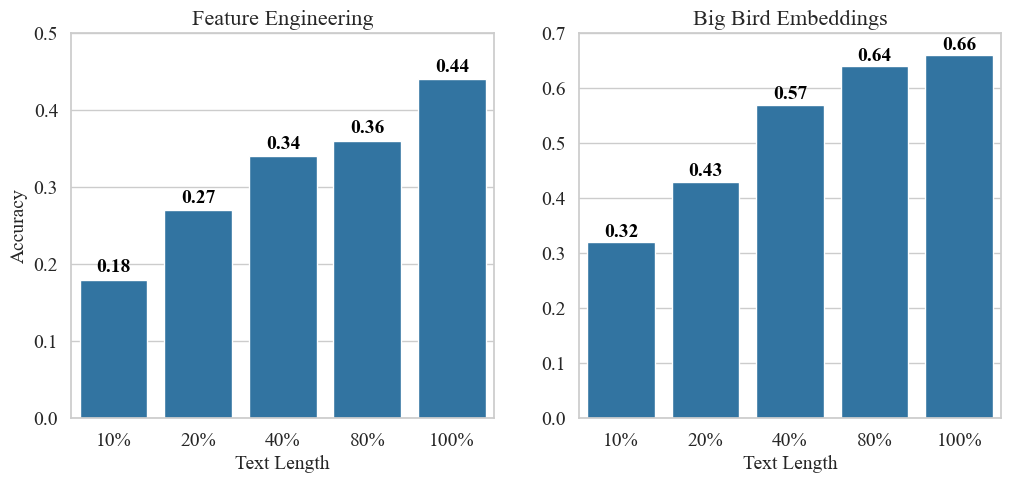

In [33]:
sns.set(font='Times New Roman', font_scale=1.8, style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
matplotlib.rcParams['font.size'] = 14

accuracies_normal = [acc_normal_10, acc_normal_20, acc_normal_40, acc_normal_80, acc_normal_full]
accuracies_bigbird = [acc_bigbird_10, acc_bigbird_20, acc_bigbird_40, acc_bigbird_80, acc_bigbird_full]
labels = ['10%', '20%', '40%', '80%', '100%']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=labels, y=accuracies_normal, ax=axes[0], color='#ff7f0e')
sns.barplot(x=labels, y=accuracies_bigbird, ax=axes[1], color='#f9d71c')

axes[0].set_title('Feature Engineering', fontsize=16)
axes[1].set_title('Big Bird Embeddings', fontsize=16)

[axe.set_xlabel('Text Length', fontsize=14) for axe in axes]
axes[0].set_ylabel('Accuracy', fontsize=14)

axes[0].set_ylim(0, 0.5)
axes[1].set_ylim(0, 0.7)

# set font tick size to 14
[axe.tick_params(labelsize=14) for axe in axes]

# add accuracy scores to the plot
for i, v in enumerate(accuracies_normal):
    axes[0].text(i - 0.2, v + 0.01, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(accuracies_bigbird):
    axes[1].text(i - 0.2, v + 0.01, str(round(v, 2)), color='black', fontweight='bold')
    
